In [8]:
import pandas as pd 
import numpy as np 
import yfinance as yf
from math import log
import matplotlib.pyplot as plt

## A. Stock Tickers

In [2]:
Stocks = ["FDX", "NKE", "CAT", "ADBE"]

In [3]:
tickers_df = yf.download(Stocks, 
                      start='2016-01-01', 
                      end='2023-01-01', 
                      progress=False, auto_adjust=True)

tickers_df.head()

Close                                         High             \
                 ADBE        CAT         FDX        NKE       ADBE        CAT   
Date                                                                            
2016-01-04  91.970001  55.742802  131.045090  57.099674  92.000000  55.816593   
2016-01-05  92.339996  55.160690  132.159744  57.897881  92.849998  56.111740   
2016-01-06  91.019997  54.291641  128.614822  57.071815  91.500000  54.808156   
2016-01-07  89.110001  52.422325  122.968407  55.549648  91.400002  53.717714   
2016-01-08  87.849998  51.889412  123.078079  54.640076  89.989998  52.906046   

                                         Low                         \
                   FDX        NKE       ADBE        CAT         FDX   
Date                                                                  
2016-01-04  134.306834  57.461651  90.540001  53.881705  130.469498   
2016-01-05  132.232838  58.092791  91.410004  54.455604  130.094896   
2016-01-06  130.834991  57.582296  90.239998  53.799722  128.167128   
2016-01-07  126.769202  56.858337  88.709999  52.192763  122.694308   
2016-01-08  125.380472  56.422122  87.629997  51.594259  122.794835   

                            Open                                     Volume  \
                  NKE       ADBE        CAT         FDX        NKE     ADBE   
Date                                                                          
2016-01-04  56.487097  91.769997  54.832748  133.767783  56.719134  2993800   
2016-01-05  57.285303  92.010002  56.062543  131.163867  57.285303  1821300   
2016-01-06  56.756245  91.099998  54.094875  130.259399  56.895465  1674000   
2016-01-07  55.484678  89.400002  53.356977  126.083963  56.050849  2717800   
2016-01-08  54.445165  89.680000  52.742075  123.891229  55.744574  2263400   

                                        
                CAT      FDX       NKE  
Date                                    
2016-01-04  8586900  3331500  11626800  
2016-01-05  6139100  1698500   9220600  
2016-01-06  6639300  1931500   6551600  
2016-01-07  8601500  3371200  10881300  
2016-01-08  8278500  2386700  11191300

In [4]:
returns = tickers_df['Close'].applymap(log).diff()[1:]
stats = returns.agg(['mean', 'std', 'var'])
annual_returns = stats.transpose()['mean'] * 252
annual_covar = returns.cov() * 252

In [14]:
stats

,ADBE,CAT,FDX,NKE
mean,0.000737,0.000825,0.000158,0.000407
std,0.021508,0.019563,0.021552,0.019219
var,0.000463,0.000383,0.000464,0.000369


## B. Adjusted Prices vs. Unadjusted Prices

#### The adjusted prices accounts for stock splits, or reverse splits. The unadjusted will have gaps. 

## C. Calculate the Efficient Frontier

In [5]:
from qpsolvers import solve_qp

In [6]:
class create_efficient_frontier():
    
    def __init__(self, returns, covar):
        self.returns = np.array(returns)
        self.covar = np.array(covar)
        self.n =len(self.covar)
        self.tickers = list(returns.index)

    def get_portfolio(self, return_target):
        """for a given target return create lowest variance long-only portfolio"""
        P, q = self.covar, np.array([0.] * self.n)
        G, h = None,None 
        A = np.array([annual_returns, np.array([1.0] * self.n)])
        b = np.array([return_target, 1.0])
        lb, ub = np.array([0.] * self.n),np.array([1.] * self.n)

        self.portfolio = solve_qp(P, q, G, h, A, b, lb, ub, solver='quadprog')  # specify solver 02/02/2023
        return {"portfolio":self.portfolio, "risk_ret":self.risk_return()}  # return (allocation , risk-return)

    def risk_return(self):
        """return the risk and return for this portfolio"""
        return np.sqrt(self.portfolio.dot(self.covar.dot(self.portfolio))), self.returns.dot(self.portfolio)

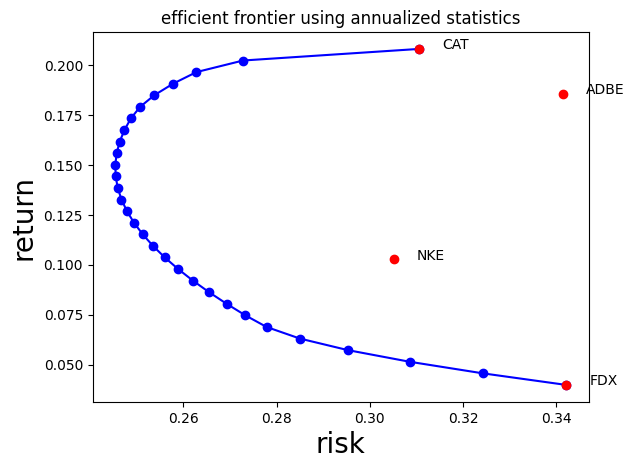

In [9]:
# loop through range of returns to create 20 portfolios on the efficient frontier
    
ef = create_efficient_frontier(annual_returns, annual_covar)
min_return, max_return = min(annual_returns), max(annual_returns)
frontier = np.array([ef.get_portfolio(r)['risk_ret'] for r in np.linspace(min_return, max_return, 30)]).T

# plot the efficient frontier in the Markowitz risk-return space

plt.plot(frontier[0], frontier[1], 'o-', color='blue') # plot the efficient frontier

for n, r, s in zip(annual_returns.index, annual_returns, np.sqrt(np.diag(annual_covar))):
    plt.plot([s], [r], 'o', color='red')
    plt.text(s+0.005, r, n)
    
plt.title('efficient frontier using annualized statistics')
plt.xlabel('risk', fontsize=20)
plt.ylabel('return', fontsize=20)
plt.show()

## 4. Minimum Variance Potfolio

In [10]:
frontier1 = np.array([ef.get_portfolio(r) for r in np.linspace(min_return, max_return, 20)]).T
frontier1_portfolio = pd.DataFrame([p['portfolio'] for p in frontier1], columns=ef.tickers)
frontier1_rr = pd.DataFrame([p['risk_ret'] for p in frontier1], columns=['risk','return'])

minVar = [i for i,r in enumerate(frontier1_rr['risk']) if r == frontier1_rr['risk'].min()]

print('minimum variance portfolio')
display(frontier1_rr.iloc[minVar, :])
display(frontier1_portfolio.iloc[minVar, :])

minimum variance portfolio


,risk,return
12,0.245407,0.146052


,ADBE,CAT,FDX,NKE
12,0.216365,0.323629,0.137754,0.322253


## 5. Uncorrelated Frontier

#### Same Mean and Variance 

#### Uncorrelated

#### If the stocks had the same mean and variance their risk reward would be the same. The efficient frontier would just be a single point.